# **Import Libraries**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
!mkdir data/glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [80]:
import re
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score , f1_score

import tensorflow as tf
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras import models, layers

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [54]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **Data Reading and Preprocessing**

In [55]:
num_of_words = 32000
max_num_of_words = 50
num_of_dimensions = 300

### Data Reading and Cleaning

In [56]:
df = pd.read_csv('/content/drive/MyDrive/CHATGPTSentimentAnalysis/file.csv')
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [57]:
# Cleaning functions
def remove_links(tweet):
    return re.sub("(http[s]?:\S+)", "", tweet)

def remove_shortwords(tweet):
    tweet = re.sub("'", "", tweet)
    tweet = tweet.split()
    clean_tweet = filter(lambda word: len(word) > 1, tweet)
    return " ".join(clean_tweet)

def remove_mentions(tweet):
    return re.sub("@[A-Za-z0-9_]+", "", tweet)

def remove_stopwords(tweet):
    stopwords_list = set(stopwords.words('english'))
    tweet = tweet.split()
    clean_tweet = filter(lambda word: word not in stopwords_list, tweet)
    return " ".join(clean_tweet)

def remove_nonwords(tweet):
    return re.sub('[^\w]', ' ', tweet)

def clean_text(tweet):
    tweet = remove_links(tweet)
    tweet = remove_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_stopwords(tweet)
    tweet = remove_nonwords(tweet)
    tweet = remove_shortwords(tweet)
    tweet = tweet.strip()
    return tweet

# Apply cleaning functions using map and reduce
cleaned_tweets = reduce(lambda acc, func: list(map(func, acc)), [clean_text], df['tweets'])
df['Tweets'] = cleaned_tweets
print(df[['tweets', 'Tweets']])

                                                   tweets  \
0       ChatGPT: Optimizing Language Models for Dialog...   
1       Try talking with ChatGPT, our new AI system wh...   
2       ChatGPT: Optimizing Language Models for Dialog...   
3       THRILLED to share that ChatGPT, our new model ...   
4       As of 2 minutes ago, @OpenAI released their ne...   
...                                                   ...   
219289  Other Software Projects Are Now Trying to Repl...   
219290  I asked #ChatGPT to write a #NYE Joke for SEOs...   
219291  chatgpt is being disassembled until it can onl...   
219292  2023 predictions by #chatGPT. Nothing really s...   
219293   From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0   

                                                   Tweets  
0             chatgpt optimizing language models dialogue  
1       try talking chatgpt new ai system optimized di...  
2       chatgpt optimizing language models dialogue ai...  
3       thrilled share chat

### Show Majority of tweets & Wordcloud

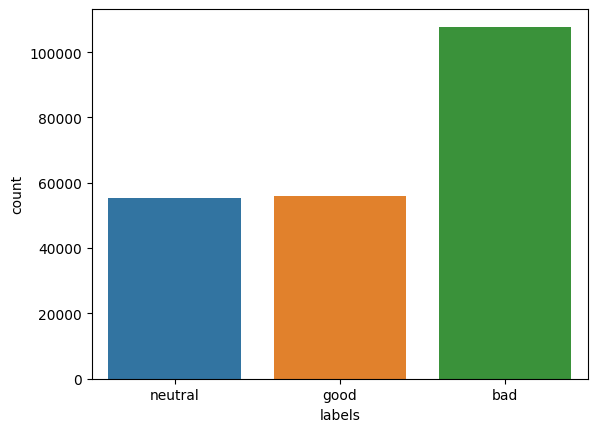

In [58]:
tweets_majority=sns.countplot(data=df, x='labels')
plt.show()
tweets_majority_fig = tweets_majority.get_figure()
tweets_majority_fig.savefig('/content/drive/MyDrive/CHATGPTSentimentAnalysis/Majority of tweets.png')

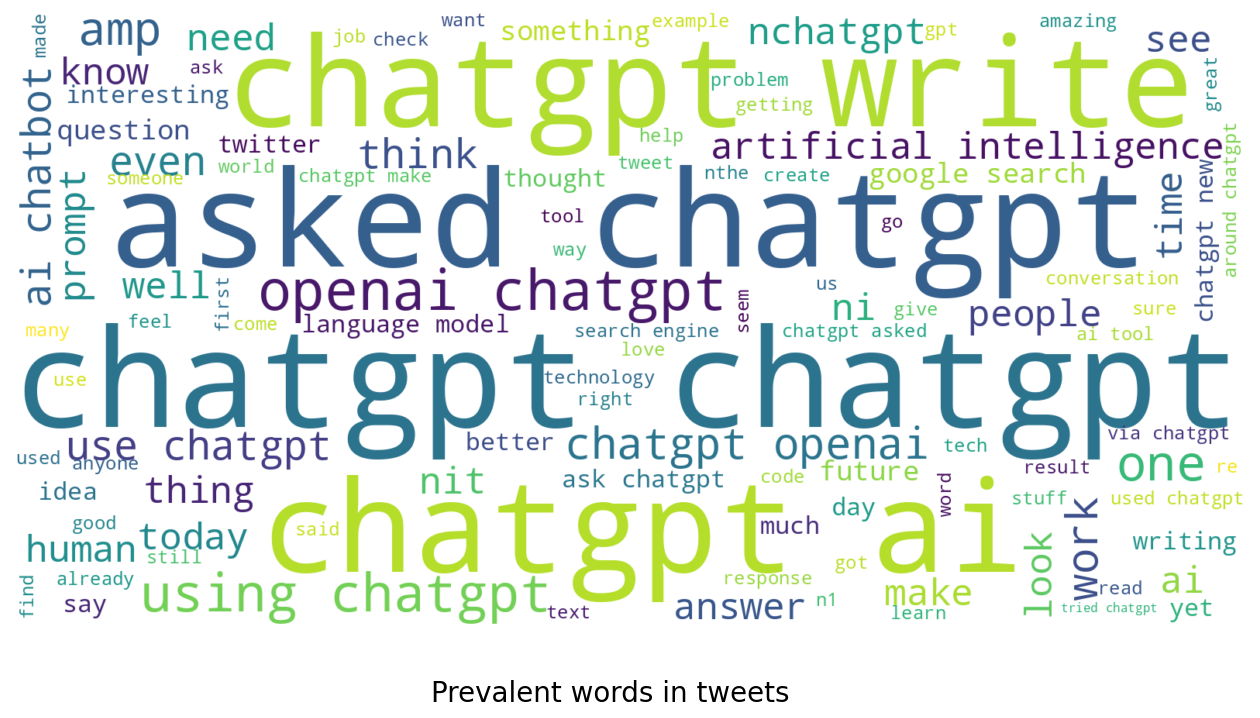

In [59]:
stopwords = set(STOPWORDS)
def show_wordcloud(data, mask=None, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,mask=mask, background_color="white").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
show_wordcloud(df['Tweets'], title = 'Prevalent words in tweets')

### Tokenization

In [60]:
tokenized_tweet = df['Tweets'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

0    [chatgpt, optimizing, language, models, dialogue]
1    [try, talking, chatgpt, new, ai, system, optim...
2    [chatgpt, optimizing, language, models, dialog...
3    [thrilled, share, chatgpt, new, model, optimiz...
4    [minutes, ago, released, new, chatgpt, nand, u...
Name: Tweets, dtype: object

### Lemmatization

In [61]:
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

df['Tweets'] = tokenized_tweet
df.head()

,Unnamed: 0,tweets,labels,Tweets
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimizing language model dialogue
1,1,"Try talking with ChatGPT, our new AI system wh...",good,try talking chatgpt new ai system optimized di...
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimizing language model dialogue ai ...
3,3,"THRILLED to share that ChatGPT, our new model ...",good,thrilled share chatgpt new model optimized dia...
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,minute ago released new chatgpt nand use right


In [62]:
df.drop(['Unnamed: 0','tweets'],axis=1,inplace=True)

### Splittig the dataset to training and testing

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df.Tweets, df.labels, test_size=0.2, random_state=42)
print(f'number of training data: {X_train.shape[0]}')
print(f'number of testing data: {X_test.shape[0]}')

number of training data: 175435
number of testing data: 43859


### Generating Training and testing Data Files

In [64]:
training_data=pd.DataFrame({'Tweets':X_train[:], 'labels':y_train[:]})
testing_data=pd.DataFrame({'Tweets':X_test[:], 'labels':y_test[:]})
training_data.to_csv('/content/drive/MyDrive/CHATGPTSentimentAnalysis/training_data.csv')
testing_data.to_csv('/content/drive/MyDrive/CHATGPTSentimentAnalysis/testing_data.csv')

# **Text Processing**

In [65]:
tokenizer = Tokenizer(num_words=num_of_words,filters=string.punctuation)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [66]:
data_description = X_train.apply(lambda x: len(x.split(' ')))
data_description_df=pd.DataFrame(data_description.describe())
data_description_df

,Tweets
count,175435.000000
mean,12.629202
std,7.920655
min,1.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,49.000000


In [67]:
max_num_of_words=49
X_train = pad_sequences(X_train_sequences, maxlen=max_num_of_words)
X_test = pad_sequences(X_test_sequences, maxlen=max_num_of_words)
print(f'Shape of samples: {X_train.shape}')

Shape of samples: (175435, 49)


In [68]:
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))
y_test[0]

array([1., 0., 0.], dtype=float32)

# **Reading Glove Word Embeddings**

In [69]:
embedding_dict = {}
glove = open(f'/content/drive/MyDrive/CHATGPTSentimentAnalysis/glove.6B.300d.txt', encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = vector
glove.close()

In [70]:
embedding_matrix = np.zeros((num_of_words, 300))
for w, i in tokenizer.word_index.items():
    if i < num_of_words:
        vect = embedding_dict.get(w)
        if vect is not None:
            embedding_matrix[i] = vect
    else:
        break
print ('Embedding Matrix Shape: ',embedding_matrix.shape)

Embedding Matrix Shape:  (32000, 300)


# **Model Building,Training & Evaluation**


## **Convolutional Neural Network(CNN) Architecture**

In [71]:
def build_CNN(Conv1D_1,Conv1D_2,Conv1D_3,_learning_rate,embedding_trainable,model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer'))
    if Conv1D_1:
      model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
      model.add(MaxPooling1D(3))

    if Conv1D_2:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    if Conv1D_3:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(3, activation='softmax',name='Output_Layer'))
    model.layers[0].set_weights([embedding_matrix])
    if embedding_trainable:
       model.layers[0].trainable = True
    else:
       model.layers[0].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate), metrics=['accuracy',f1_score,precision_score, recall_score])
    model.summary()
    return model


## **CNN Model Training**

In [72]:
cnn_model = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Model')
cnn_model_history = cnn_model.fit(X_train, y_train,epochs=10, verbose=1,batch_size=128,validation_split=0.2)

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 49, 128)           614528    
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 16, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 128)           262272    
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                         

## **Fucntion for Plotting The Accuracy and Loss**


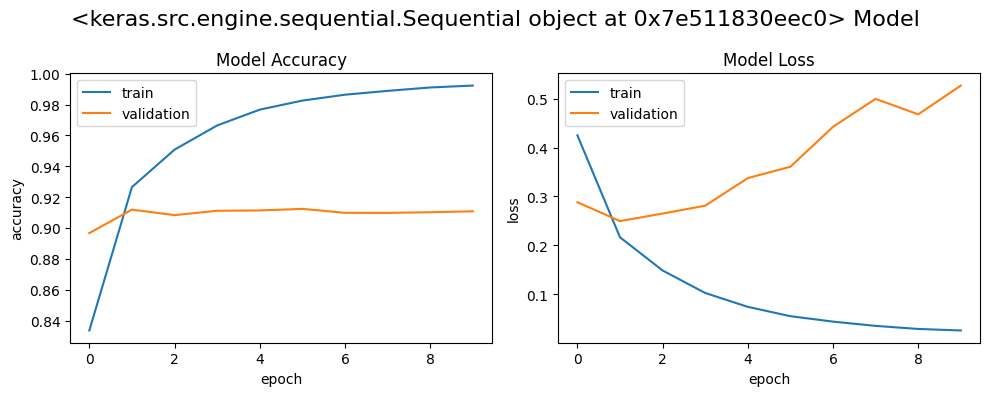

In [73]:
def plotting_model_measurements(history, model_name):
    title_name = f'{model_name} Model'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    fig.suptitle(title_name, fontsize=16)

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

    plt.savefig(f'/content/drive/MyDrive/CHATGPTSentimentAnalysis/Model Accuracy and Loss.png')
    plt.draw()
    plt.tight_layout()
plotting_model_measurements(cnn_model_history,cnn_model)

## **Testing The Model Trials**

In [74]:
training_score = cnn_model.evaluate(X_train, y_train)
testing_score = cnn_model.evaluate(X_test, y_test)
print(f'Training Accuaracy: {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy: {round(testing_score[1]*100,1)}%')

1371/1371 [==============================] - 7s 5ms/step - loss: 0.5419 - accuracy: 0.9092 - f1_score: 0.9092 - precision_score: 0.9101 - recall_score: 0.9084
Training Accuaracy: 97.8%
Testing Accuaracy: 90.9%


## **Saving The Models**

In [75]:
cnn_model.save('/content/drive/MyDrive/CHATGPTSentimentAnalysis/CNN_modelSaved')

# **New tweets Predictions**

## **Loading CNN Model**

In [76]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CHATGPTSentimentAnalysis/Saved Models/CNN/CNN_modelSaved',
                                              custom_objects={"f1_m": f1_score, "precision_m": precision_score, "recall_m": recall_score })
cnn_model.summary()

Model: "CNN_Trial-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_12 (Conv1D)          (None, 49, 128)           614528    
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 16, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 16, 128)           262272    
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 5, 128)            0         
 ng1D)                                                           
                                                       

In [77]:
def sentiment_category(label_id):
    label = ''
    if label_id==1:
        label = 'positive'
    elif label_id==2:
        label = 'neutral'
    else:
        label = 'negative'
    return label

## **Predictions**

In [81]:
# Postive Example
tweet = "Excited to share my experience with ChatGPT! Its conversational skills are mind-blowing, making tasks a breeze! #AI #ChatGPT"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=[lemmatizer.lemmatize(word) for word in new_tweet]
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = "Absolutely frustrated with ChatGPT! It constantly provides inaccurate information, making it unreliable for any serious use. A disappointing experience overall. #ChatGPT #Disappointed"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=[lemmatizer.lemmatize(word) for word in new_tweet]
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# neutral Example
tweet = "ChatGPT, a versatile language model by OpenAI, offers applications from creative writing to answering user queries. #ChatGPT #OpenAI"  # neutral

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=[lemmatizer.lemmatize(word) for word in new_tweet]
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')


1/1 [==============================] - 0s 333ms/step
Text: Excited to share my experience with ChatGPT! Its conversational skills are mind-blowing, making tasks a breeze! #AI #ChatGPT
Label ID: 1
Label Name: positive
Polarity: 0.9453442692756653


1/1 [==============================] - 0s 19ms/step
Text: Absolutely frustrated with ChatGPT! It constantly provides inaccurate information, making it unreliable for any serious use. A disappointing experience overall. #ChatGPT #Disappointed
Label ID: 0
Label Name: negative
Polarity: 1.0


1/1 [==============================] - 0s 19ms/step
Text: ChatGPT, a versatile language model by OpenAI, offers applications from creative writing to answering user queries. #ChatGPT #OpenAI
Label ID: 2
Label Name: neutral
Polarity: 0.9998983144760132


